In [1]:
import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass

from process_gen_utils import *
from process_gens import *


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


In [2]:



processGens=ProcessGens()
processGens.init_with_mode(process_gens_modes=["full_instruct"])

root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics=processGens.get_params()

examples_df, completions_df=get_dfs(processGens=processGens, num_beams_list=num_beams_list)
# compare_metric=instance_metrics[0]
# compare_metric='final_num_exact_match'
# compare_metric="example_comet"
# compare_metric="BLEU_4"


#if test
# print("calculate_gen_summary_dict")
# gen_summary_dict=calculate_gen_summary_dict(root_folder=root_folder, num_beams_list=num_beams_list, models=models,task_names=task_names, suite_name=suite_name)
# print("calculate instance dict")
# instance_stats_dict=calculate_instance_stats_dict(root_folder=root_folder, num_beams_list=num_beams_list, models=models, task_names=task_names, suite_name=suite_name, instance_metrics=instance_metrics)
# print("get_metrics_dict")
# metrics_dicts=get_metrics_dict(gen_summary_dict=gen_summary_dict, custom_metrics=custom_metrics, instance_stats_dict=instance_stats_dict)




Init: process_gens_mode ['full_instruct']


----------------
 NOTE: ONLY PRINTING 4 tasks ----------------

calculate_gen_summary_dict
get_metrics_dict
Index(['example_themis', 'beam_num', 'task_name', 'model', 'example_idx',
       'text', 'completion_length', 'output_logprob', 'instanceID',
       'isCompletion'],
      dtype='object')
Num examples: 8120
Num completions: 1740


In [3]:
completions_df['task_name'].unique()

array([0, 1, 2, 3, 4, 5])

In [4]:

def compare_beams_by_metric(analysis_df,compare_metric,compare_beams, compare_func= lambda a,b: b-a,plot_histogram=True):

    for beam_num in compare_beams:
        filtered_df=analysis_df.loc[analysis_df['beam_num']==beam_num]
        print(f"Mean {compare_metric} for {beam_num}:\t {filtered_df[compare_metric].mean()}")
    
    compare_cols=[f"{compare_metric}_{beam_num}" for beam_num in compare_beams]
    dif_col=f'{compare_metric}_dif'
    
    
    index_cols=['instanceID',  'task_name', 'model']
    
    result = analysis_df[analysis_df['beam_num'].isin(compare_beams)][ ["beam_num"]+index_cols+[compare_metric]]

    pivoted = analysis_df.pivot_table(
        index=index_cols,
        columns='beam_num',
        values=compare_metric,
        # aggfunc='mean'  # or 'first' if there's only one value per group
    ).reset_index()

    pivoted = pivoted.rename(columns={
        compare_beams[0]: compare_cols[0],
        compare_beams[1]: compare_cols[1]
    })

    print("Pivot head:\n\n")
    print(pivoted.head(1))


    pivoted[dif_col] = pivoted.apply(lambda row: compare_func(row[compare_cols[0]],row[compare_cols[1]]), axis=1)
    print(f"Mean Change:{pivoted[dif_col].mean()}")
    print(f"Median Change:{pivoted[dif_col].median()}")
    if(plot_histogram):
        pivoted.hist(column=dif_col,bins=40)

last_beam=num_beams_list[-1]
first_beam=num_beams_list[0]
print(completions_df.columns)
# compare_beams_by_metric(analysis_df=completions_df,compare_metric='output_logprob', compare_beams=[last_beam, first_beam])
compare_beams_by_metric(analysis_df=completions_df,compare_metric=compare_metric, compare_beams=[last_beam, first_beam])
# plot_keys("completion_logprob","BLEU")

# x=completions_df[(completions_df["task_name"]==0) & (completions_df["model"]==0) & (completions_df["beam_num"]==last_beam) & (completions_df["instanceID"]=="id33626")   ]
# print(x)


# beam_num=next(iter(processGens.beam_num_to_summary))
# instance_generations_by_id=get_instance_generations_by_id()
# get_beam_means()
# get_beam_probs()
# check_completion_logprob(beam_num)
# check_sentence_logprob(beam_num)
# see_overlap_per_instance_generation(num_beams_list[-1], num_instances=10)

# if(processGens.metrics_df is not None):
#     ax1 = processGens.metrics_df.plot.scatter(x='beam_num',y='comet',c='DarkBlue')



Index(['example_themis', 'beam_num', 'task_name', 'model', 'example_idx',
       'text', 'completion_length', 'output_logprob', 'instanceID',
       'isCompletion'],
      dtype='object')


KeyError: 'final_num_exact_match'

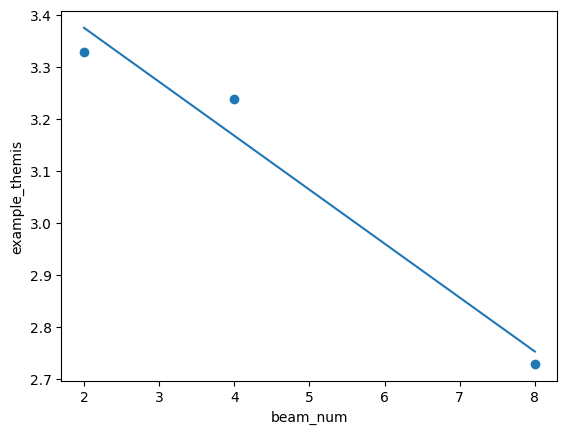

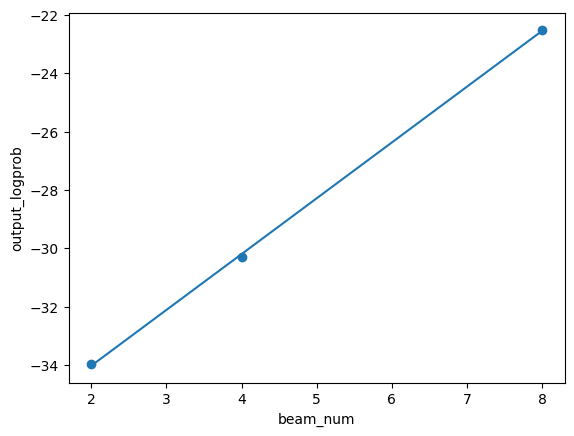

In [5]:
# def plot_beam_averages(analysis_df):

# plot_beam_averages(completions_df)



def plot_grouped(xlabel, ylabel, group_metric, analysis_df):
    keep_cols=list(set([xlabel, ylabel, group_metric]))
    grouped_df = analysis_df[keep_cols].groupby(group_metric, as_index=False).mean()
    plot_keys(grouped_df, xlabel, ylabel)

plot_grouped(xlabel="beam_num", ylabel=compare_metric, group_metric="beam_num", analysis_df=completions_df)
plot_grouped(xlabel="beam_num", ylabel="output_logprob", group_metric="beam_num", analysis_df=completions_df)

In [6]:


@dataclass(frozen=False)
class SimplifiedCompletion:
    rating:str
    completion:str
    evaluation:str

@dataclass(frozen=False)
class BeamOutputsPerInstance:
    instance_id:int
    reference:str
    prompt:str
    simplifiedCompletions:Dict[str,SimplifiedCompletion]



from helm.common.general import ensure_directory_exists, write, asdict_without_nones


def analyze_completion_by_beam(processGens:ProcessGens, num_instances:int=20):
    instances_dict=processGens.instances_dict
    

    # model, task, beam_num
    indexed_by_model={}
    counter=0
    for model_num,model in enumerate(models):
        indexed_by_task={}
        for task_num, task_name in enumerate(task_names):
            
            task_ids = list(instances_dict[0][task_num][num_beams_list[0]].keys())
            indexed_by_id={}
            for id in task_ids:
                simplifiedCompletions={}
                instance_id=None
                reference=None
                prompt=None
                for beam_num in num_beams_list:
                    instance_generation=instances_dict[model_num][task_num][beam_num][id]
                    simplifiedCompletion=None
                    if instance_generation.stats_dict and "completion_themis" in instance_generation.stats_dict.keys():
                        rating = instance_generation.stats_dict["example_themis"] if instance_generation.stats_dict else -1
                        simplifiedCompletion= SimplifiedCompletion(completion=instance_generation.completion, evaluation=instance_generation.evaluation, rating=rating)
                    else:
                        completionExample=instance_generation.examples[0]
                        # print(completionExample.stats_dict)
                        # rating = completionExample.stats_dict["example_themis"] if instance_generation.stats_dict else -1
                        simplifiedCompletion= SimplifiedCompletion(completion=instance_generation.completion, evaluation=completionExample.evaluation, rating=rating)

                    simplifiedCompletions[beam_num]=simplifiedCompletion
                    instance_id=instance_generation.instance_id
                    reference=instance_generation.reference
                    prompt=instance_generation.prompt
                beamOutputsPerInstance = BeamOutputsPerInstance(instance_id=instance_id, prompt=prompt, reference=reference, simplifiedCompletions=simplifiedCompletions)
                beamOutputsPerInstanceDict= asdict_without_nones(beamOutputsPerInstance)
                indexed_by_id[id]=beamOutputsPerInstanceDict
            indexed_by_task[task_name]=indexed_by_id
        indexed_by_model[model]=indexed_by_task
    return indexed_by_model
analyze_completion_by_beam(processGens, num_instances=10)

UnboundLocalError: local variable 'rating' referenced before assignment